In [12]:
from models import RPN, FastRCNN, RPN_Loss, FastRCNN_Loss, FasterRCNN, AnchorGenerator, Backbone
from dataloader import get_dataloader
from dataset import VOCDataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import utils as U
import torch
import glob
import torch

In [4]:
ds = VOCDataset(2007, 'trainval')

/tmp/ipykernel_451862/3481633757.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('outputs/checkpoint_step2_40000.pt', map_location='cpu')


In [44]:
model = FastRCNN()
state = torch.load('outputs/checkpoint_step2_999.pt', map_location='cpu')
model.load_state_dict(state['model'])
dl,_ = get_dataloader(ds, shuffle=False, augment=False, normalize=True, batch_size=1, roi_proposal_path='outputs/roi_proposals.pkl',augment_th=0)

/tmp/ipykernel_451862/2885356143.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('outputs/checkpoint_step2_999.pt', map_location='cpu')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


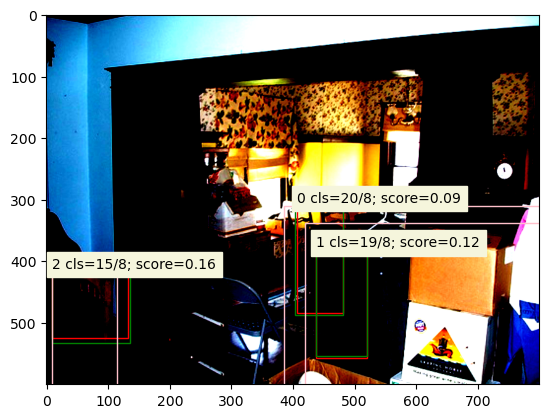

In [45]:
for batch in dl:
    imgs = batch['x'][0]
    inputs, targets = batch['x'], batch['y']
    model.train()
    img = imgs[0].permute(1,2,0)
    with torch.no_grad():
        out1, out2 = model(inputs, targets)
        locs = U.xyxy_2_xywh(out1.locs)
        rois = U.xyxy_2_xywh(out1.roi_proposals[:, 1:])
        n = locs.size(0)
        scores = out1.cls_softmax.max(1)[0]
        targets = out2
        targets['class_ids']
        j = 0
        for i in range(n):
            tgt_class = targets['class_ids'][i]
            if tgt_class == 0:
                continue
            if j == 3:
                break
            cls = out1.cls[i].item()
            if cls == 0 or tgt_class == 0:
                continue
            st = f'{i} cls={cls}/{tgt_class}; score={scores[i].item():.2f}'
            x,y,w,h = locs[i].numpy()
            plt.text(x,y, st, c='black', backgroundcolor='beige')
            rec = patches.Rectangle((x,y),w,h, ec='red', fc='none')
            plt.gca().add_patch(rec)

            x,y,w,h = rois[i].numpy()
            rec = patches.Rectangle((x,y),w,h, ec='green', fc='none')
            plt.gca().add_patch(rec)

            x,y,w,h = targets['bboxes'][i].numpy()
            rec = patches.Rectangle((x,y),w,h, ec='pink', fc='none')
            plt.gca().add_patch(rec)
            j += 1
        # print(out1, out2)
    plt.imshow(img)

    break